<a href="https://colab.research.google.com/github/Triniti0/klasifikasi-penyakit-daun-cabai/blob/main/Eksperimen_Optimasi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import json
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

Mounted at /content/drive


In [3]:
EXPERIMENT_NAME = "Partial_FineTuning"
BASE_SAVE_DIR = "/content/drive/MyDrive/Seminar hasil/Experiments"

SAVE_DIR = os.path.join(BASE_SAVE_DIR, EXPERIMENT_NAME)
os.makedirs(SAVE_DIR, exist_ok=True)

RESULTS_FILE = os.path.join(SAVE_DIR, "grid_results.csv")
BEST_MODEL_INFO = os.path.join(SAVE_DIR, "best_model_info.json")

# Load Dataset

In [4]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset(batch_size):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/train",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/val",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/test",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=False
    )

    class_names = train_ds.class_names

    def preprocess(x, y):
        return preprocess_input(x), y

    train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
    val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)
    test_ds = test_ds.map(preprocess).prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

# Model Partial Fine-Tuning

In [5]:
def build_partial_finetune(dropout_rate, learning_rate, optimizer_name, num_classes):

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    total_layers = len(base_model.layers)
    freeze_until = int(total_layers * 0.7)

    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False

    for layer in base_model.layers[freeze_until:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

implementasi LR Scheduler

In [6]:
#cosine annealing
def cosine_annealing(epoch, lr):
    initial_lr = lr
    total_epochs = 50
    return initial_lr * (1 + np.cos(np.pi * epoch / total_epochs)) / 2

In [7]:
#step decay
def step_decay(epoch, lr):
    drop = 0.5
    epochs_drop = 10
    if epoch % epochs_drop == 0 and epoch:
        return lr * drop
    return lr

# Hyperparameter Tuning

In [8]:
#parameter input
learning_rates = [1e-5, 1e-4]
optimizers = ["sgd", "adam"]
batch_sizes = [16, 32]
dropouts = [0.2, 0.3]
schedulers = ["cosine", "step"]
epochs = 50

In [9]:
#checkpoin training kalau berhenti
if os.path.exists(RESULTS_FILE):
    results_df = pd.read_csv(RESULTS_FILE)
    completed = set(results_df["Config_ID"])
    best_val_acc = results_df["Val Accuracy"].max()
else:
    results_df = pd.DataFrame()
    completed = set()
    best_val_acc = 0

# Pelatihan Model

In [10]:
def config_id(lr, opt, bs, dr, sch):
    return f"LR{lr}_OPT{opt}_BS{bs}_DR{dr}_SCH{sch}"

for lr in learning_rates:
    for opt in optimizers:
        for bs in batch_sizes:
            for dr in dropouts:
                for sch in schedulers:

                    cid = config_id(lr, opt, bs, dr, sch)

                    if cid in completed:
                        print("Skip:", cid)
                        continue

                    print("\nRunning:", cid)

                    train_ds, val_ds, test_ds, class_names = load_dataset(bs)
                    model = build_partial_finetune(dr, lr, opt, len(class_names))

                    if sch == "cosine":
                        scheduler_cb = LearningRateScheduler(
                            lambda epoch, lr_current: cosine_annealing(epoch, lr)
                        )
                    else:
                        scheduler_cb = LearningRateScheduler(step_decay)

                    callbacks = [
                        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
                        scheduler_cb
                    ]

                    start_time = time.time()

                    model.fit(
                        train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=1
                    )

                    training_time = time.time() - start_time
                    val_loss, val_acc = model.evaluate(val_ds, verbose=0)

                    if val_acc > best_val_acc:
                        best_val_acc = val_acc

                        model_filename = f"Best_Model_{EXPERIMENT_NAME}_{cid}.h5"
                        model_path = os.path.join(SAVE_DIR, model_filename)
                        model.save(model_path)

                        best_metadata = {
                            "Experiment_Name": EXPERIMENT_NAME,
                            "Config_ID": cid,
                            "Learning Rate": lr,
                            "Optimizer": opt,
                            "Batch Size": bs,
                            "Dropout": dr,
                            "Scheduler": sch,
                            "Validation Accuracy": float(val_acc),
                            "Model Path": model_path
                        }

                        with open(BEST_MODEL_INFO, "w") as f:
                            json.dump(best_metadata, f, indent=4)

                        print("New Best Model Saved:", model_filename)

                    new_row = {
                        "Config_ID": cid,
                        "Learning Rate": lr,
                        "Optimizer": opt,
                        "Batch Size": bs,
                        "Dropout": dr,
                        "Scheduler": sch,
                        "Val Accuracy": val_acc,
                        "Training Time": training_time
                    }

                    results_df = pd.concat([results_df, pd.DataFrame([new_row])])
                    results_df.to_csv(RESULTS_FILE, index=False)

Skip: LR1e-05_OPTsgd_BS16_DR0.2_SCHcosine
Skip: LR1e-05_OPTsgd_BS16_DR0.2_SCHstep
Skip: LR1e-05_OPTsgd_BS16_DR0.3_SCHcosine
Skip: LR1e-05_OPTsgd_BS16_DR0.3_SCHstep
Skip: LR1e-05_OPTsgd_BS32_DR0.2_SCHcosine
Skip: LR1e-05_OPTsgd_BS32_DR0.2_SCHstep
Skip: LR1e-05_OPTsgd_BS32_DR0.3_SCHcosine
Skip: LR1e-05_OPTsgd_BS32_DR0.3_SCHstep
Skip: LR1e-05_OPTadam_BS16_DR0.2_SCHcosine
Skip: LR1e-05_OPTadam_BS16_DR0.2_SCHstep
Skip: LR1e-05_OPTadam_BS16_DR0.3_SCHcosine
Skip: LR1e-05_OPTadam_BS16_DR0.3_SCHstep
Skip: LR1e-05_OPTadam_BS32_DR0.2_SCHcosine
Skip: LR1e-05_OPTadam_BS32_DR0.2_SCHstep
Skip: LR1e-05_OPTadam_BS32_DR0.3_SCHcosine
Skip: LR1e-05_OPTadam_BS32_DR0.3_SCHstep
Skip: LR0.0001_OPTsgd_BS16_DR0.2_SCHcosine
Skip: LR0.0001_OPTsgd_BS16_DR0.2_SCHstep
Skip: LR0.0001_OPTsgd_BS16_DR0.3_SCHcosine
Skip: LR0.0001_OPTsgd_BS16_DR0.3_SCHstep
Skip: LR0.0001_OPTsgd_BS32_DR0.2_SCHcosine

Running: LR0.0001_OPTsgd_BS32_DR0.2_SCHstep
Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes

# Evaluasi

load best model dan konfigurasinya

In [11]:
with open(BEST_MODEL_INFO, "r") as f:
    best_info = json.load(f)

print("\n===== BEST MODEL SUMMARY =====")
for k, v in best_info.items():
    print(f"{k}: {v}")

best_model = tf.keras.models.load_model(best_info["Model Path"])


===== BEST MODEL SUMMARY =====
Experiment_Name: Partial_FineTuning
Config_ID: LR0.0001_OPTsgd_BS16_DR0.2_SCHstep
Learning Rate: 0.0001
Optimizer: sgd
Batch Size: 16
Dropout: 0.2
Scheduler: step
Validation Accuracy: 0.9918962717056274
Model Path: /content/drive/MyDrive/Seminar hasil/Experiments/Partial_FineTuning/Best_Model_Partial_FineTuning_LR0.0001_OPTsgd_BS16_DR0.2_SCHstep.h5


In [12]:
train_ds, val_ds, test_ds, class_names = load_dataset(best_info["Batch Size"])

train_loss, train_acc = best_model.evaluate(train_ds, verbose=0)
val_loss, val_acc = best_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)

print("\nTrain Acc:", train_acc)
print("Val Acc:", val_acc)
print("Test Acc:", test_acc)

if train_acc - val_acc > 0.10:
    print("⚠ Overfitting detected")
elif val_acc > train_acc:
    print("⚠ Possible underfitting")
else:
    print("✔ Model stable")

Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.

Train Acc: 0.9996582269668579
Val Acc: 0.9918962717056274
Test Acc: 0.9967741966247559
✔ Model stable


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

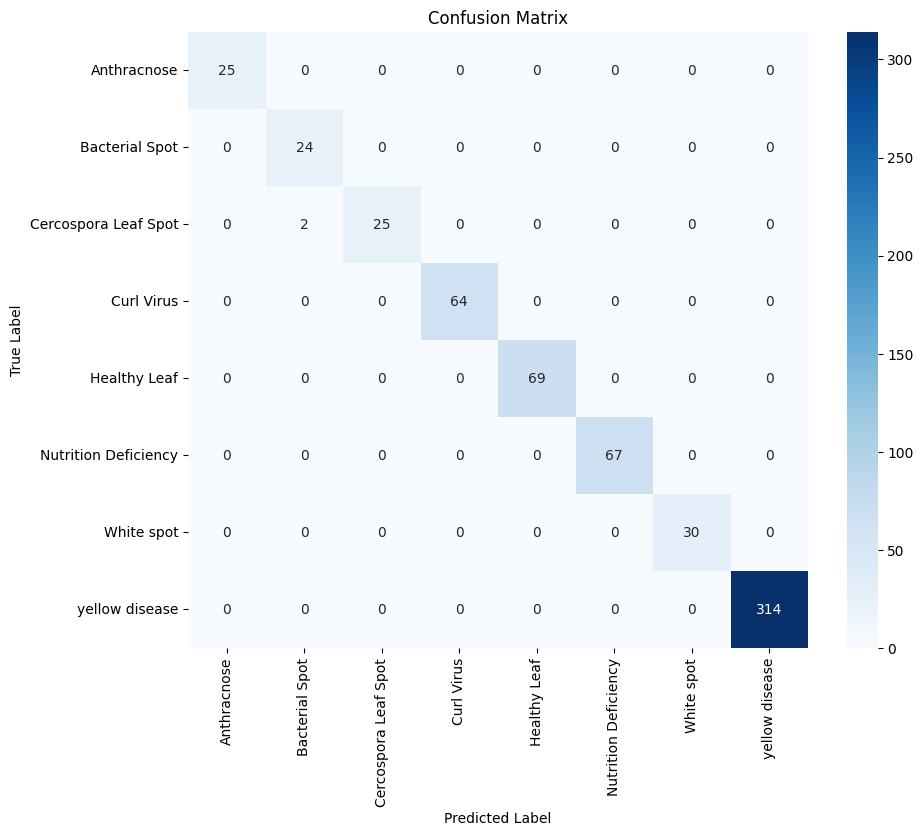

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

#confusion matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
#waktu inferensi
sample = next(iter(test_ds))[0]

start = time.time()
_ = best_model.predict(sample)
inference_time = (time.time() - start) / len(sample)

print("Inference Time per Image:", inference_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Inference Time per Image: 0.006438583135604858


In [15]:
#ukuran file model
size_mb = os.path.getsize(best_info["Model Path"]) / (1024*1024)
print("Model Size (MB):", size_mb)

Model Size (MB): 17.275917053222656


## Plotting Model Terbaik

In [19]:
print(best_info)

# Extract best model parameters from best_info
best_lr = best_info['Learning Rate']
best_opt = best_info['Optimizer']
best_bs = best_info['Batch Size']
best_dr = best_info['Dropout']
best_sch = best_info['Scheduler']

# Load dataset with the best batch size
train_ds_best, val_ds_best, test_ds_best, class_names_best = load_dataset(best_bs)

# Build the best model architecture
best_model_for_history = build_partial_finetune(best_dr, best_lr, best_opt, len(class_names_best))

# Re-initialize the weights to ensure we get the history from scratch
# If we don't re-initialize, it will continue training from the loaded 'best_model'
# This assumes the user wants the full training curve, not continued training.
# A simple way to re-initialize weights is to rebuild the model.

# Setup callbacks for the best model's training
if best_sch == "cosine":
    scheduler_cb_best = LearningRateScheduler(
        lambda epoch, lr_current: cosine_annealing(epoch, best_lr)
    )
else:
    scheduler_cb_best = LearningRateScheduler(step_decay)

callbacks_best = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    scheduler_cb_best
]

print(f"\nRetraining best model (Config ID: {best_info['Config_ID']}) to capture training history...")

# Train the model and capture history
retrained_history = best_model_for_history.fit(
    train_ds_best,
    validation_data=val_ds_best,
    epochs=epochs, # Use the same number of epochs as in grid search
    callbacks=callbacks_best,
    verbose=1
)

print("Retraining complete. History captured.")

{'Experiment_Name': 'Partial_FineTuning', 'Config_ID': 'LR0.0001_OPTsgd_BS16_DR0.2_SCHstep', 'Learning Rate': 0.0001, 'Optimizer': 'sgd', 'Batch Size': 16, 'Dropout': 0.2, 'Scheduler': 'step', 'Validation Accuracy': 0.9918962717056274, 'Model Path': '/content/drive/MyDrive/Seminar hasil/Experiments/Partial_FineTuning/Best_Model_Partial_FineTuning_LR0.0001_OPTsgd_BS16_DR0.2_SCHstep.h5'}
Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.

Retraining best model (Config ID: LR0.0001_OPTsgd_BS16_DR0.2_SCHstep) to capture training history...
Epoch 1/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 51s 48ms/step - accuracy: 0.5791 - loss: 1.2962 - val_accuracy: 0.7131 - val_loss: 0.8330 - learning_rate: 1.0000e-04
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9423 - loss: 0.2233 - val_accuracy: 0.9060 - val_loss: 0.2703 - learning_rate: 1.0000e-04
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.969

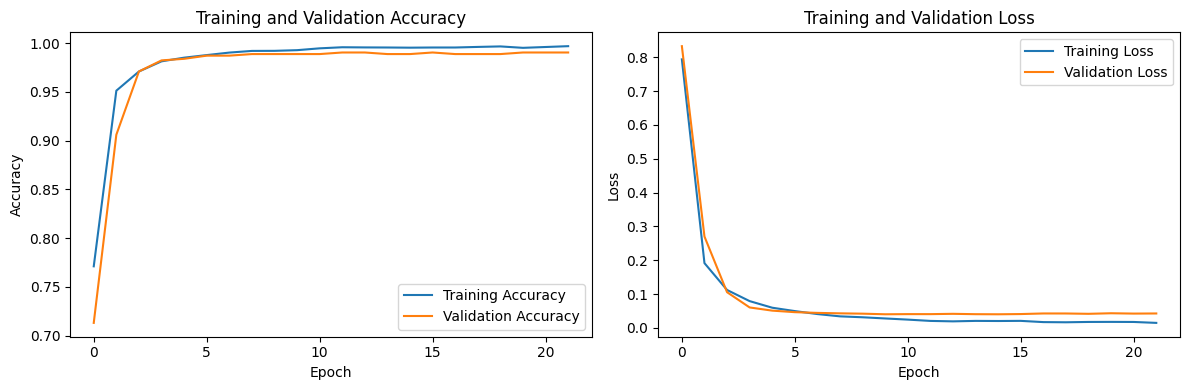

In [20]:
import matplotlib.pyplot as plt

history_dict = retrained_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()